In [1]:
import numpy as np
import xarray as xr
import pandas as pd
from tensorflow.keras.layers import Input, Conv2D, Dense, Flatten, Activation, MaxPool2D, SeparableConv2D, AveragePooling2D, concatenate,add,Reshape
from tensorflow.keras.models import Model, save_model, load_model
from tensorflow.keras.utils import plot_model
from tensorflow import concat
import matplotlib.pyplot as plt
#from sklearn.preprocessing import MinMaxScaler
import datetime
%matplotlib inline

run_num = 0

In [2]:
class MinMaxScalerX:
    def __init__(self,in_array,dim=None):
        """
        Create a min/max scaler object that scales
        across dims.  If dims is not provided, perform
        the scaling across all dims.
        Input is an xarray object
        """
        self.min = in_array.min(dim=dim)
        self.max = in_array.max(dim=dim)
        self.delta = self.max-self.min
        self.mid = 0.5*(self.max+self.min)
    def fit_transform(self,new_array):
        return (new_array-self.min)/self.delta
    
    def inverse_transform(self,out_array):
        return out_array*self.delta+self.min
        
        

In [3]:
ds_path = "/scr/sci/mhayman/holodec/holodec-ml-data/"


# ds_file = "synthetic_holograms_v02.nc"  # 3 particle data (raw data)
ds_file = "synthetic_holograms_v02_ft_multipart_real_imag_amplitude_float.nc" # 3 particle data
channel_name = "channels"
data_rescale = 2

In [74]:
num_epochs = 10

In [60]:
run_num = 0

In [4]:
ds = xr.open_dataset(ds_path+ds_file)  # file with mean (DC) value removed

In [5]:
ds['particle_data'].dims

('particle_property', 'particle_number', 'hologram_number')

In [6]:
split_index = 7000  # number of training+validation points
valid_index = 2000  # number of validation points
all_labels = ds['particle_data'].transpose('hologram_number','particle_property','particle_number')
#ll_labels = ds['particle_data'].stack(particle_line=('particle_property','particle_number'))

train_labels = all_labels.isel(hologram_number=slice(valid_index,split_index))
test_labels = all_labels.isel(hologram_number=slice(split_index,None))
val_labels = all_labels.isel(hologram_number=slice(None,valid_index))

scaler = MinMaxScalerX(train_labels,dim=('hologram_number','particle_number'))
scaled_train_labels = scaler.fit_transform(train_labels)
scaled_val_labels = scaler.fit_transform(val_labels)
scaled_test_labels = scaler.fit_transform(test_labels)
scaled_all_labels = scaler.fit_transform(all_labels)
# scaler = MinMaxScaler()
# scaled_train_labels = scaler.fit_transform(train_labels.values)
# scaled_val_labels = scaler.fit_transform(val_labels.values)
# scaled_test_labels = scaler.transform(test_labels.values)

In [7]:
# train_labels.min(dim=('hologram_number','particle_number'))
scaled_train_labels

<xarray.DataArray 'particle_data' (hologram_number: 5000, particle_property: 4, particle_number: 3)>
array([[[0.654248, 0.728813, 0.46529 ],
        [0.700799, 0.323063, 0.522217],
        [0.187972, 0.27223 , 0.175688],
        [0.847694, 0.640837, 0.248423]],

       [[0.909695, 0.996442, 0.674188],
        [0.530361, 0.178273, 0.078894],
        [0.194781, 0.126995, 0.755139],
        [0.826316, 0.128196, 0.064605]],

       ...,

       [[0.107911, 0.697158, 0.584112],
        [0.258333, 0.19964 , 0.484277],
        [0.498588, 0.274186, 0.866492],
        [0.924819, 0.801154, 0.384308]],

       [[0.862528, 0.294617, 0.868513],
        [0.023054, 0.261544, 0.520284],
        [0.347548, 0.589763, 0.307107],
        [0.941706, 0.696046, 0.051619]]])
Coordinates:
  * particle_property  (particle_property) object 'x' 'y' 'z' 'd'
Dimensions without coordinates: hologram_number, particle_number

In [8]:
# split_index = 7000  # number of training+validation points
# valid_index = 2000  # number of validation points
# all_labels = ds['particle_data'].to_dataframe()
# train_labels = all_labels.iloc[valid_index:split_index]
# test_labels = all_labels.iloc[split_index:]
# val_labels = all_labels.iloc[:valid_index]
# scaler = MinMaxScaler()
# scaled_train_labels = pd.DataFrame(scaler.fit_transform(train_labels), index=train_labels.index, columns=train_labels.columns)
# scaled_val_labels = pd.DataFrame(scaler.fit_transform(val_labels), index=val_labels.index, columns=val_labels.columns)
# scaled_test_labels = pd.DataFrame(scaler.transform(test_labels), index=test_labels.index, columns=test_labels.columns)

In [9]:
all_labels.shape


(10000, 4, 3)

In [10]:
if channel_name is None:
    in_data = ds["image_ft"].transpose("hologram_number", "ysize", 'xsize').expand_dims("channel", 3)
else:
    in_data = ds["image_ft"].transpose("hologram_number", "ysize", "xsize",channel_name)

In [11]:
scaled_in_data = in_data / data_rescale
# scaled_in_image = in_data

In [12]:
(np.prod(all_labels.shape[1:]),)

(12,)

In [58]:
nn_input = Input(shape=scaled_in_data.shape[1:])  # input

nn_descript = 'CNN4layer_DenseNN_mae'

# conv_input = Input(shape=scaled_in_data.shape[1:])  # input
conv_1 = SeparableConv2D(8, (15, 15), padding="same")(nn_input)
act_1 = Activation("relu")(conv_1)
pool_1 = MaxPool2D(pool_size=(4, 4))(act_1)

conv_2 = Conv2D(16, (5, 5), padding="same")(pool_1)
act_2 = Activation("relu")(conv_2)
pool_2 = MaxPool2D(pool_size=(4, 4))(act_2)
conv_3 = Conv2D(32, (5, 5), padding="same")(pool_2)
act_3 = Activation("relu")(conv_3)
pool_3 = MaxPool2D(pool_size=(4, 4))(act_3)

conv_4 = Conv2D(64, (5, 5), padding="same")(pool_3)
act_4 = Activation("relu")(conv_4)
pool_4 = MaxPool2D(pool_size=(4, 4))(act_4)

flat_c = Flatten()(pool_4)
dense_1 = Dense(64, activation="relu")(flat_c)

# #nn_descript = 'DenseNN_mae'

#filter_input = Input(shape=scaled_in_data.shape[1:])

# # use average pooling for input
# # pool_d1 = AveragePooling2D(pool_size=(4, 4))(nn_input)
# # flat_d = Flatten()(pool_d1)

# # skip average pooling
# nn_descript = 'DenseNN_noPool_mae'
# flat_d = Flatten()(nn_input)  

# dense_d1 = Dense(128, activation="relu")(flat_d)
# dense_d2 = Dense(64, activation="relu")(dense_d1)

# # dense_d3 = Dense(128, activation="relu")(dense_d2)
# # dense_d4 = Dense(64, activation="relu")(dense_d3)
# dense_d5 = Dense(32, activation="relu")(dense_d2)
# dense_d6 = Dense(16, activation="relu")(dense_d5)
# dense_d7 = Dense(8, activation="relu")(dense_d6)
# dense_1 = Dense(4, activation="relu")(dense_d7)

# comb = concatenate([dense_d2,flat_c])
# dense_1 = Dense(64, activation="relu")(comb)

dense_2 = Dense(32, activation="relu")(dense_1)
dense_3 = Dense(np.prod(all_labels.shape[1:]), activation="relu")(dense_2) # encoding layer to sort particles by size
flat_out = Dense(np.prod(all_labels.shape[1:]))(dense_3)  # number of outputs determined by the parameters we are training to
out = Reshape(all_labels.shape[1:], input_shape=(np.prod(all_labels.shape[1:]),))(flat_out)
mod = Model(nn_input, out)
mod.compile(optimizer="adam", loss="mae",metrics=['acc'])
mod.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 400, 600, 3)]     0         
_________________________________________________________________
separable_conv2d_4 (Separabl (None, 400, 600, 8)       707       
_________________________________________________________________
activation_17 (Activation)   (None, 400, 600, 8)       0         
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 100, 150, 8)       0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 100, 150, 16)      3216      
_________________________________________________________________
activation_18 (Activation)   (None, 100, 150, 16)      0         
_________________________________________________________________
max_pooling2d_18 (MaxPooling (None, 25, 37, 16)        0   

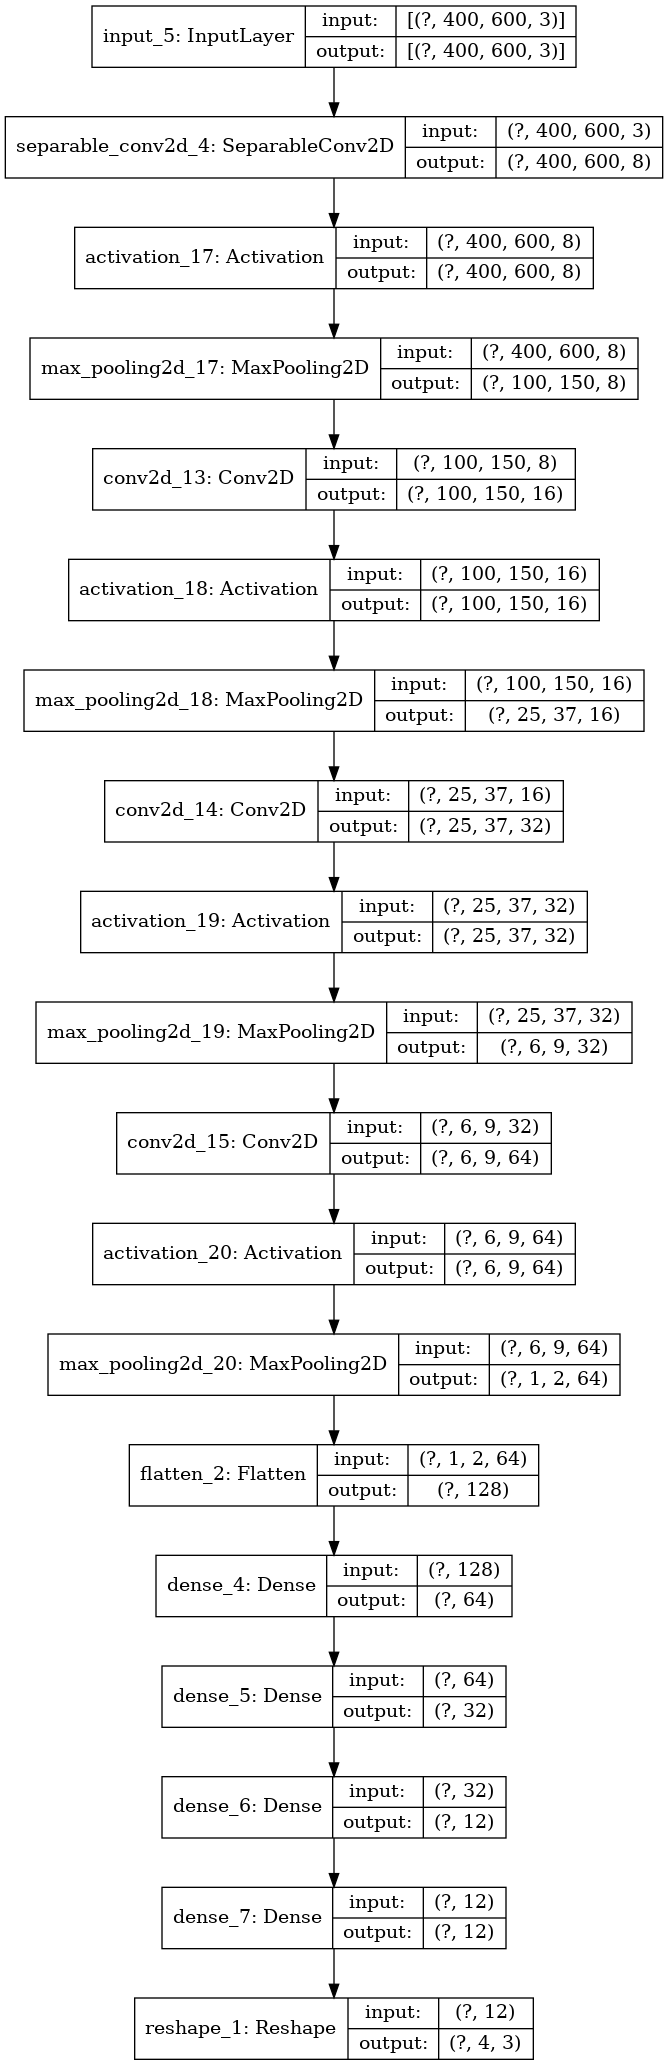

In [59]:
plot_model(mod,show_shapes=True,to_file="results/holodec_"+nn_descript+'_'+ds_file.replace(".nc","")+".png")

In [ ]:
history = mod.fit(scaled_in_data[valid_index:split_index].values,
                  scaled_train_labels.values, 
                  batch_size=16, epochs=num_epochs, verbose=1,
                  validation_data=(scaled_in_data[:valid_index].values,scaled_val_labels.values))
run_num+=1

Train on 5000 samples, validate on 2000 samples
Epoch 1/10
4160/5000 [=======================>......] - ETA: 1:00 - loss: 0.1335 - acc: 0.6596

In [ ]:
epochs = np.arange(len(history.history['loss']))+1
fig, ax = plt.subplots(1, 1, figsize=(8, 4))
ax.plot(epochs,history.history['loss'],'bo-',alpha=0.5,label='Training')
ax.plot(epochs,history.history['val_loss'],'rs-',alpha=0.5,label='Validation')
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.grid(b=True)
plt.legend()
plt.savefig("results/LossHistory_"+nn_descript+'_'+ds_file.replace(".nc","")+f"_{num_epochs}epochs_run{run_num}"+".png", dpi=200, bbox_inches="tight")

fig, bx = plt.subplots(1, 1, figsize=(8, 4))
bx.plot(epochs,history.history['acc'],'bo-',alpha=0.5,label='Training')
bx.plot(epochs,history.history['val_acc'],'rs-',alpha=0.5,label='Validation')
bx.set_xlabel('Epoch')
bx.set_ylabel('Accuracy')
bx.grid(b=True)
plt.legend()
plt.savefig("results/AccuracyHistory_"+nn_descript+'_'+ds_file.replace(".nc","")+f"_{num_epochs}epochs_run{run_num}"+".png", dpi=200, bbox_inches="tight")


In [41]:
# can skip the training process and just load the CNN model
# mod = load_model("holodec_ft_dxyz_cnn.h5")

In [ ]:
cnn_start = datetime.datetime.now()
preds_out = mod.predict(scaled_in_data.values, batch_size=64)
cnn_stop = datetime.datetime.now()
print(f"{scaled_in_data.values.shape[0]} samples in {(cnn_stop-cnn_start).total_seconds()} seconds")
print(f"for {(cnn_stop-cnn_start).total_seconds()/scaled_in_data.values.shape[0]} seconds per hologram")

In [ ]:
save_model(mod, ds_path+"/models/holodec_histogram_"+nn_descript+'_'+ds_file.replace(".nc","")+f"{num_epochs}epochs_run{run_num}"+".h5", save_format="h5")

In [ ]:
preds_out.shape

In [ ]:
preds_out_da = xr.DataArray(preds_out,dims=('hologram_number','particle_property','particle_number'),
                            coords=all_labels.coords)

In [ ]:
preds_original = scaler.inverse_transform(preds_out_da)

In [ ]:
(test_labels.max() - test_labels.min())

In [ ]:
preds_original

In [ ]:
mean_error = (preds_original[split_index:] - test_labels).mean(dim=('hologram_number','particle_number'))
std_error = (preds_original[split_index:] - test_labels).std(dim=('hologram_number','particle_number'))

In [ ]:
validation_data = {}
fig, axes = plt.subplots(2, 2, figsize=(8, 8))
for a, clabel in enumerate(all_labels.coords['particle_property'].values):
    ax=axes.ravel()[a]
    ax.scatter(test_labels.sel(particle_property=clabel), preds_original.sel(particle_property=clabel,hologram_number=slice(split_index,None)), 1, 'k')
    diag = np.linspace(test_labels.sel(particle_property=clabel).min(), test_labels.sel(particle_property=clabel).max(), 10)
    ax.plot(diag, diag, 'b--' )
    ax.set_title(clabel)
    plt.text(0.1,0.9,f"${mean_error.sel(particle_property=clabel).values:.1f} \pm {std_error.sel(particle_property=clabel).values:.1f} \mu m$",ha='left',va='top',transform=ax.transAxes)
#     validation_data[test_labels.columns[a]] = test_labels.iloc[:, a]
#     validation_data[test_labels.columns[a]+'_pred'] = preds_original[split_index:, a]
plt.savefig("results/error_scatter_"+nn_descript+'_'+ds_file.replace(".nc","")+f"{num_epochs}epochs_run{run_num}"+".png", dpi=200, bbox_inches="tight")
# validation_data_df = pd.DataFrame(validation_data)
# validation_data_df.to_csv('results/validation_data_denseNN_MultiIn_'+ds_file.replace(".nc","_")+''.join(all_labels.columns)+'.txt')
    

In [ ]:
mean_error.sel(particle_property=clabel)

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(8, 8))
for a, clabel in enumerate(all_labels.coords['particle_property'].values):
    ax=axes.ravel()[a]
    ax.hist( (preds_original.sel(particle_property=clabel,hologram_number=slice(split_index,None)).values - test_labels.sel(particle_property=clabel).values).flatten() / (test_labels.sel(particle_property=clabel).values.max() - test_labels.sel(particle_property=clabel).values.min()),
           bins=20)
    ax.set_yscale("log")
    ax.set_xlabel("Error in "+clabel)
plt.savefig("results/relative_error_histogram"+nn_descript+'_'+ds_file.replace(".nc","")+f"{num_epochs}epochs_run{run_num}"+".png", dpi=200, bbox_inches="tight")